### Recruitment Decision Analysis  
----------------------------  
This script analyzes recruitment decisions based on resume, job description, and transcript data. It includes:  
1. **Feature Extraction**: Extracts features like resume-JD similarity, sentiment analysis, text length, and skills matching from text data.  
2. **Train-Test Split**: Splits data into training (80%) and testing (20%) sets using sklearn.  
3. **Hyperparameter Tuning**: Trains Logistic Regression, Decision Tree, Random Forest, and XGBoost models with grid search for hyperparameter tuning.  
4. **Model Evaluation**: Evaluates models using metrics like accuracy, ROC AUC, and classification reports.  
5. **In-depth Statistical Analysis**: Performs logistic regression analysis using statsmodels for statistical insights.  
6. **Post-Model Analysis**: Includes feature importance visualization for the best-performing model.  

### Import necessary libraries

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import spacy
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download
download('punkt')
download('stopwords')
download('wordnet')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load spaCy model

In [5]:
nlp = spacy.load('en_core_web_sm')

# Load dataset

In [6]:
data = pd.read_excel("/content/dataset_1_2_3_combined (1).xlsx")

####E.D.A

In [7]:
print("Dataset Info:")
print(data.info())
print("\nTarget Variable Distribution:")
print(data['decision'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               1674 non-null   int64 
 1   ID                       1674 non-null   object
 2   Name                     1674 non-null   object
 3   Role                     1674 non-null   object
 4   Transcript               1674 non-null   object
 5   Resume                   1674 non-null   object
 6   decision                 1674 non-null   object
 7   Reason for decision      1674 non-null   object
 8   Job Description          1674 non-null   object
 9   num_words_in_transcript  1674 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 130.9+ KB
None

Target Variable Distribution:
decision
reject    868
select    806
Name: count, dtype: int64


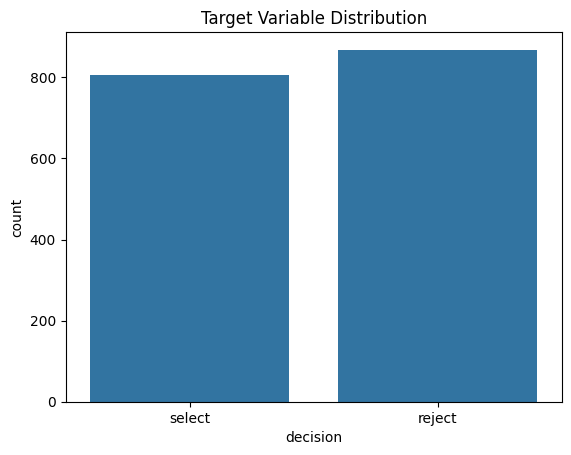

In [8]:
# Plot Target Variable Distribution
sns.countplot(x='decision', data=data)
plt.title("Target Variable Distribution")
plt.show()


In [9]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Unnamed: 0                 0
ID                         0
Name                       0
Role                       0
Transcript                 0
Resume                     0
decision                   0
Reason for decision        0
Job Description            0
num_words_in_transcript    0
dtype: int64


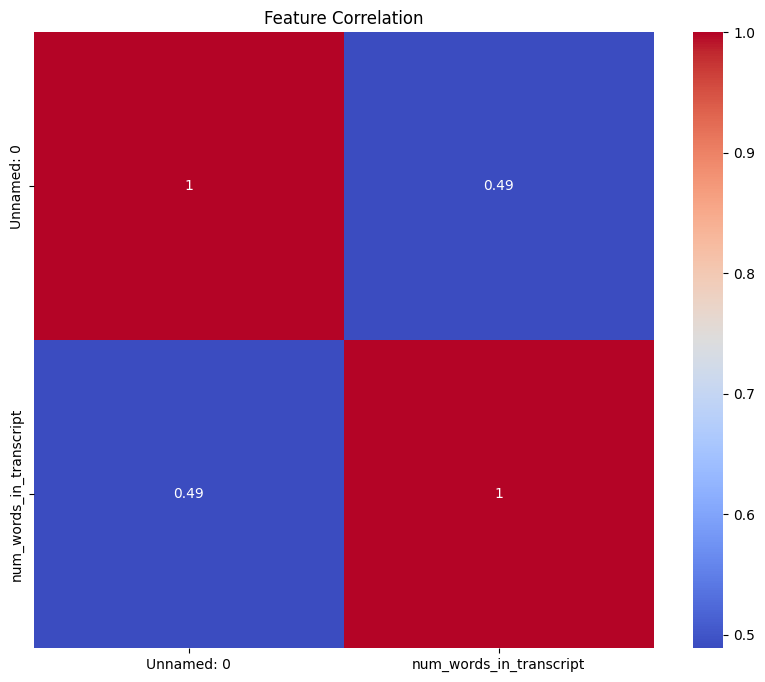

In [10]:
# Correlation heatmap (only for numerical features)
plt.figure(figsize=(10, 8))
# Select only numerical features for correlation calculation
numerical_data = data.select_dtypes(include=np.number)
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# Step 2: Preprocessing


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

# Rest of the code remains the same

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=5b1fb262c9453279137bc78c0fd44d418e31448b4c64586fa58f405c1ca0b3e5
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [15]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from autocorrect import Speller


class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.spell_checker = Speller(lang='en')
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """
        Cleans the input text by lowercasing, removing special characters, tokenizing, removing stopwords,
        lemmatizing, and optionally stemming.
        """
        if pd.isna(text):
            return ""

        # Lowercase the text
        text = str(text).lower()

        # Remove special characters, numbers, and punctuation
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        # Remove stopwords and apply lemmatization
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]

        # Optionally apply stemming (comment out if not needed)
        # tokens = [self.stemmer.stem(token) for token in tokens]

        # Apply spelling correction
        tokens = [self.spell_checker(token) for token in tokens]

        return ' '.join(tokens)

    def preprocess_pipeline(self, text, correct_spelling=False, use_stemming=False):
        """
        Full preprocessing pipeline with optional spelling correction and stemming.
        """
        if pd.isna(text):
            return ""

        # Clean the text
        text = self.clean_text(text)

        # Optional: Correct spelling
        if correct_spelling:
            text = ' '.join([self.spell_checker(word) for word in text.split()])

        # Optional: Apply stemming
        if use_stemming:
            text = ' '.join([self.stemmer.stem(word) for word in text.split()])

        return text


### Define Helper Classes

In [17]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00


In [44]:
# Install required packages
!pip install textblob gensim textstat

# Import required libraries
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
import textstat

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

class FeatureExtractor:
    def __init__(self):
        """Initialize feature extractor with required tools and models."""
        self.tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
        self.svd = TruncatedSVD(n_components=50)
        self.scaler = StandardScaler()
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Preprocess text by tokenizing, lemmatizing, and removing stopwords."""
        tokens = word_tokenize(str(text).lower())
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        return ' '.join(tokens)

    def extract_features(self, resume, jd, transcript):
        """Extract features from resume, job description, and transcript."""
        # Handle NaN values
        resume = str(resume) if pd.notna(resume) else ""
        jd = str(jd) if pd.notna(jd) else ""
        transcript = str(transcript) if pd.notna(transcript) else ""

        # Preprocess texts
        resume_processed = self.preprocess_text(resume)
        jd_processed = self.preprocess_text(jd)
        transcript_processed = self.preprocess_text(transcript)

        features = {}

        try:
            # TF-IDF Similarities
            tfidf_matrix = self.tfidf.fit_transform([resume_processed, jd_processed, transcript_processed])
            features['resume_jd_similarity'] = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0, 0]
            features['resume_transcript_similarity'] = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[2:3])[0, 0]
            features['jd_transcript_similarity'] = cosine_similarity(tfidf_matrix[1:2], tfidf_matrix[2:3])[0, 0]

            # Sentiment Analysis (VADER)
            for text, prefix in [(resume, 'resume'), (jd, 'jd'), (transcript, 'transcript')]:
                sentiment = self.sentiment_analyzer.polarity_scores(text)
                features.update({
                    f'{prefix}_sentiment_pos': sentiment['pos'],
                    f'{prefix}_sentiment_neg': sentiment['neg'],
                    f'{prefix}_sentiment_neu': sentiment['neu'],
                    f'{prefix}_sentiment_compound': sentiment['compound']
                })

            # Text Statistics
            for text, prefix in [(resume, 'resume'), (jd, 'jd'), (transcript, 'transcript')]:
                features[f'{prefix}_length'] = len(text.split())
                features[f'{prefix}_char_length'] = len(text)
                features[f'{prefix}_avg_word_length'] = sum(len(word) for word in text.split()) / max(len(text.split()), 1)
                features[f'{prefix}_sentence_count'] = len(text.split('.'))

            # Readability Metrics
            for text, prefix in [(resume, 'resume'), (jd, 'jd')]:
                try:
                    features[f'{prefix}_readability'] = textstat.flesch_reading_ease(text)
                    features[f'{prefix}_gunning_fog'] = textstat.gunning_fog(text)
                    features[f'{prefix}_smog'] = textstat.smog_index(text)
                    features[f'{prefix}_automated_readability'] = textstat.automated_readability_index(text)
                    features[f'{prefix}_coleman_liau'] = textstat.coleman_liau_index(text)
                except:
                    features[f'{prefix}_readability'] = 0
                    features[f'{prefix}_gunning_fog'] = 0
                    features[f'{prefix}_smog'] = 0
                    features[f'{prefix}_automated_readability'] = 0
                    features[f'{prefix}_coleman_liau'] = 0

            # Skills Matching
            technical_skills = [
                'python', 'java', 'javascript', 'c++', 'sql', 'machine learning',
                'data analysis', 'deep learning', 'nlp', 'cloud computing',
                'aws', 'azure', 'docker', 'kubernetes', 'git', 'agile'
            ]
            soft_skills = [
                'leadership', 'communication', 'teamwork', 'problem solving',
                'analytical', 'creative', 'organized', 'management'
            ]

            features['technical_skills_resume'] = sum(skill in resume.lower() for skill in technical_skills)
            features['technical_skills_jd'] = sum(skill in jd.lower() for skill in technical_skills)
            features['soft_skills_resume'] = sum(skill in resume.lower() for skill in soft_skills)
            features['soft_skills_jd'] = sum(skill in jd.lower() for skill in soft_skills)
            features['skills_match_ratio'] = (features['technical_skills_resume'] + features['soft_skills_resume']) / \
                                             max((features['technical_skills_jd'] + features['soft_skills_jd']), 1)

            # Lexical Diversity
            for text, prefix in [(resume_processed, 'resume'), (jd_processed, 'jd'), (transcript_processed, 'transcript')]:
                tokens = text.split()
                features[f'{prefix}_lexical_diversity'] = len(set(tokens)) / max(len(tokens), 1)
                features[f'{prefix}_unique_words'] = len(set(tokens))

            # Topic Modeling with LDA
            if resume_processed and jd_processed and transcript_processed:
                dictionary = Dictionary([resume_processed.split(), jd_processed.split(), transcript_processed.split()])
                corpus = [dictionary.doc2bow(doc.split()) for doc in [resume_processed, jd_processed, transcript_processed]]
                try:
                    lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)
                    resume_topics = dict(lda_model[corpus[0]])
                    jd_topics = dict(lda_model[corpus[1]])
                    for i in range(3):
                        features[f'resume_topic_{i}'] = resume_topics.get(i, 0.0)
                        features[f'jd_topic_{i}'] = jd_topics.get(i, 0.0)
                except:
                    for i in range(3):
                        features[f'resume_topic_{i}'] = 0.0
                        features[f'jd_topic_{i}'] = 0.0

            # Education and Experience Indicators
            education_terms = ['bachelor', 'master', 'phd', 'degree', 'university', 'college']
            experience_terms = ['year', 'years', 'experience', 'worked', 'work']
            features['education_mentions'] = sum(term in resume.lower() for term in education_terms)
            features['experience_mentions'] = sum(term in resume.lower() for term in experience_terms)

            # Named Entity Recognition
            try:
                resume_blob = TextBlob(resume)
                jd_blob = TextBlob(jd)
                features['resume_proper_nouns'] = len([word for word, tag in resume_blob.tags if tag == 'NNP'])
                features['jd_proper_nouns'] = len([word for word, tag in jd_blob.tags if tag == 'NNP'])
            except:
                features['resume_proper_nouns'] = 0
                features['jd_proper_nouns'] = 0

            # SVD-based dimensional reduction of TF-IDF
            svd_features = self.svd.fit_transform(tfidf_matrix)
            for i in range(min(10, svd_features.shape[1])):
                features[f'svd_component_{i}'] = svd_features[0, i]

        except Exception as e:
            print(f"Error in feature extraction: {str(e)}")
            return {}

        return features

# Function to load and process data
def process_data(file_path):
    print("Starting data processing...")

    # Initialize feature extractor
    feature_extractor = FeatureExtractor()

    try:
        # Load the dataset
        data = pd.read_excel(file_path)
        print(f"Loaded dataset with {len(data)} rows")

        # Extract features
        features = []
        for idx, row in data.iterrows():
            try:
                print(f"Processing row {idx + 1}/{len(data)}", end='\r')
                feature_dict = feature_extractor.extract_features(
                    row['Resume'],
                    row['Job Description'],
                    row['Transcript']
                )
                features.append(feature_dict)
            except Exception as e:
                print(f"\nError processing row {idx}: {str(e)}")
                features.append({})

        # Convert to DataFrame and return features
        X = pd.DataFrame(features)

        print("\nFeature extraction completed.")
        print(f"Feature matrix shape: {X.shape}")

        return X

    except Exception as e:
        print(f"Error in data processing: {str(e)}")
        return None

# Example usage
file_path = '/content/dataset_1_2_3_combined (1) (1).xlsx'
X = process_data(file_path)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Streaming output truncated to the last 5000 lines.
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Processing row 1459/1674
***********************************

In [46]:
## Example usage
file_path = '/content/dataset_1_2_3_combined (1) (1).xlsx'
X = process_data(file_path)

# Access the 'decision' column from the original data for labels
y = data['decision']  # Assuming 'decision' is the target column

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Streaming output truncated to the last 5000 lines.
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Processing row 1458/1674
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


***********************************

# Train-Test Split

In [69]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [70]:
from sklearn.pipeline import Pipeline # Import Pipeline class from sklearn.pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))
])

# Hyperparameter Tuning and Model Training

In [1]:
!pip install scikit-learn==1.2.2

In [2]:
!pip install --upgrade xgboost

In [60]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [73]:
# Import required library for CatBoost
from catboost import CatBoostClassifier

# Define models and parameter grids
models = {
    'Logistic Regression': (
        LogisticRegression(random_state=42, max_iter=1000),
        {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
    ),
    'XGBoost': (
        XGBClassifier(random_state=42, use_label_encoder=False),
        {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
    ),
    'CatBoost': (
        CatBoostClassifier(random_state=42, verbose=0),
        {'iterations': [100, 200, 300], 'depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
    )
}

# Train and tune models
best_models = {}
for name, (model, params) in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)

    # Handle XGBoost and CatBoost separately for label encoding
    if name in ['XGBoost', 'CatBoost']:
        # Create a LabelEncoder object
        le = LabelEncoder()

        # Fit the encoder to your training labels and transform them
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)  # Transform y_test using the same encoder

        # Use encoded labels for training XGBoost and CatBoost
        grid_search.fit(X_train_scaled, y_train_encoded)
    else:
        # For other models, use original y_train
        grid_search.fit(X_train_scaled, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 100}
Tuning XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:53:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Tuning CatBoost...
Best parameters for CatBoost: {'depth': 3, 'iterations': 200, 'learning_rate': 0.01}


# Model Evaluation

In [74]:
# Evaluate models
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")

    # Predict the test labels
    y_pred = model.predict(X_test_scaled)

    # If the model is XGBoost or CatBoost, inverse-transform the predictions
    if name in ['XGBoost', 'CatBoost']:
        y_pred = le.inverse_transform(y_pred)  # Use the same LabelEncoder object (le)

    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Print evaluation metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



Evaluating Logistic Regression...
Accuracy: 0.818
ROC AUC: 0.932

Classification Report:
              precision    recall  f1-score   support

      reject       0.82      0.83      0.83       174
      select       0.81      0.81      0.81       161

    accuracy                           0.82       335
   macro avg       0.82      0.82      0.82       335
weighted avg       0.82      0.82      0.82       335


Evaluating Decision Tree...
Accuracy: 0.776
ROC AUC: 0.904

Classification Report:
              precision    recall  f1-score   support

      reject       0.76      0.83      0.79       174
      select       0.80      0.71      0.75       161

    accuracy                           0.78       335
   macro avg       0.78      0.77      0.77       335
weighted avg       0.78      0.78      0.78       335


Evaluating Random Forest...
Accuracy: 0.806
ROC AUC: 0.933

Classification Report:
              precision    recall  f1-score   support

      reject       0.81      0.82

#  Post-Model Analysis

In [ ]:
# Feature importance for Random Forest


Feature Importance for Random Forest:
                      Feature  Importance
4        resume_sentiment_neg    0.134225
7            jd_sentiment_pos    0.117781
10      jd_sentiment_compound    0.085107
6   resume_sentiment_compound    0.079417
3        resume_sentiment_pos    0.070312
..                        ...         ...
40             soft_skills_jd    0.000131
34                    jd_smog    0.000000
39         soft_skills_resume    0.000000
56        resume_proper_nouns    0.000000
57            jd_proper_nouns    0.000000

[61 rows x 2 columns]


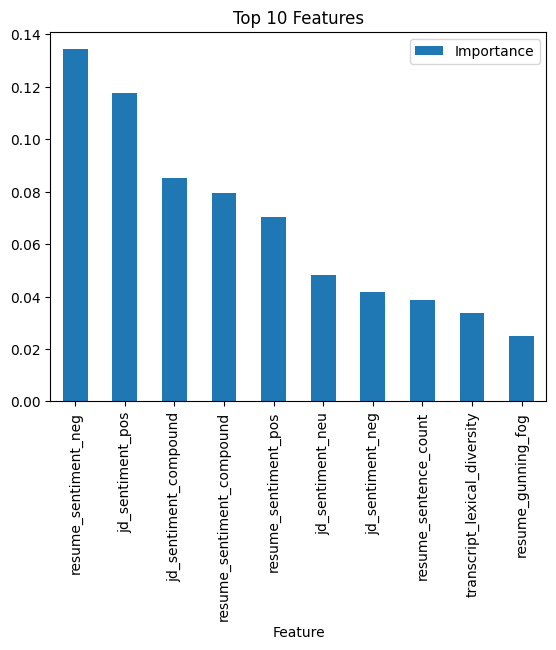

In [75]:
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importance for Random Forest:")
    print(feature_importances)
    feature_importances.head(10).plot(kind='bar', x='Feature', y='Importance', title='Top 10 Features')

## SHAP Analysis for Best Model

In [78]:
!pip install shap

In [86]:

!pip install pdp

  Preparing metadata (setup.py) ... done
  Created wheel for pdp: filename=pdp-0.3.0-py3-none-any.whl size=6603 sha256=2ca4ad51509c1d7b9451c9696186f31ad1b219b3195cb6a5fbfa9b0ad4f6d0a7
  Stored in directory: /root/.cache/pip/wheels/e3/9d/87/c2e79511cf74e5a6ac49e3d3aa88d3c198e1c30b9d5e011ddf
Successfully built pdp


In [87]:
import shap
import pdp
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for probability conversion
from sklearn.preprocessing import LabelEncoder

### Step 3: Access the Trained Model and Data

In [88]:
# Assuming 'best_models', 'X_train_scaled', 'X_test_scaled', 'y_train', 'y_test' are available

best_xgb_model = best_models['XGBoost']  # Get the best XGBoost model

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training labels and transform them
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)  # Transform y_test using the same encoder

# Use encoded labels for training and SHAP analysis with XGBoost
best_xgb_model.fit(X_train_scaled, y_train_encoded) # Fit the model using encoded labels

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:20:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

## Step 4: Generate SHAP Plots

In [90]:
# Create the SHAP explainer
explainer = shap.Explainer(best_xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled)



In [92]:
# Ensure X_test is a DataFrame with proper column names
if isinstance(X_test_scaled, pd.DataFrame):
    X_test_scaled_df = X_test_scaled
else:
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

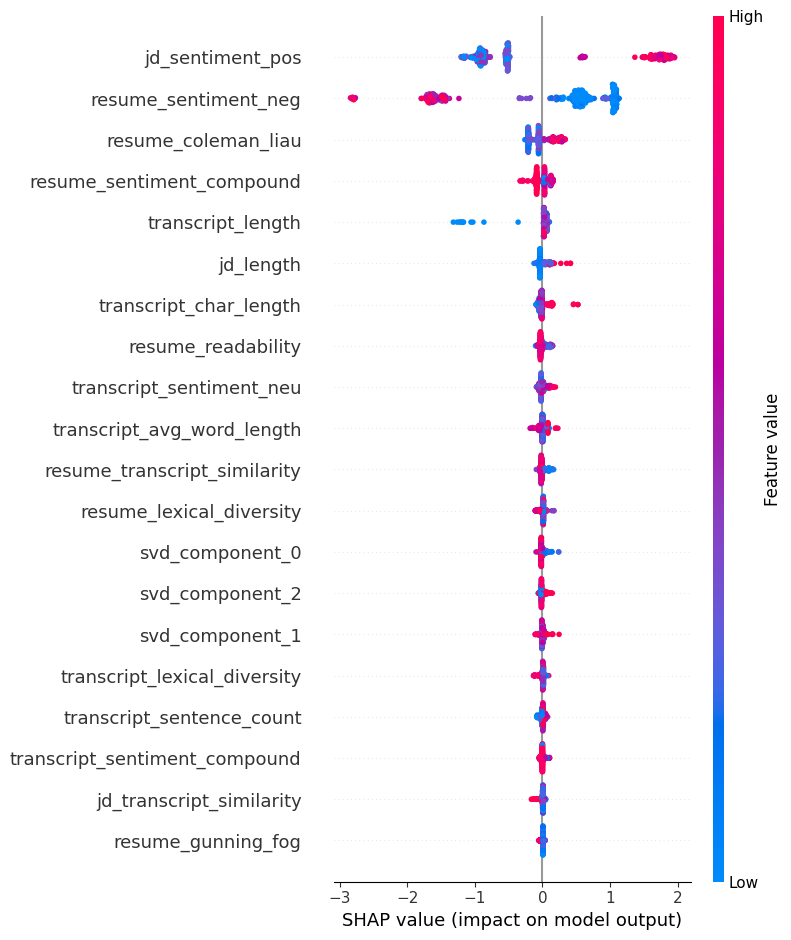

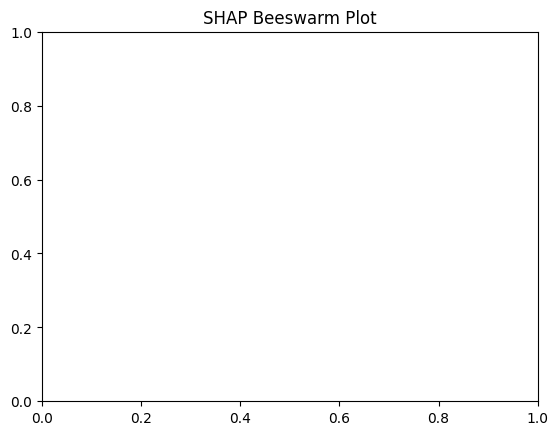

In [93]:
# a) SHAP Beeswarm Plot
shap.summary_plot(shap_values, X_test, plot_type="dot")
plt.title("SHAP Beeswarm Plot")
plt.show()



## b) SHAP Waterfall Plots (for 3 instances)

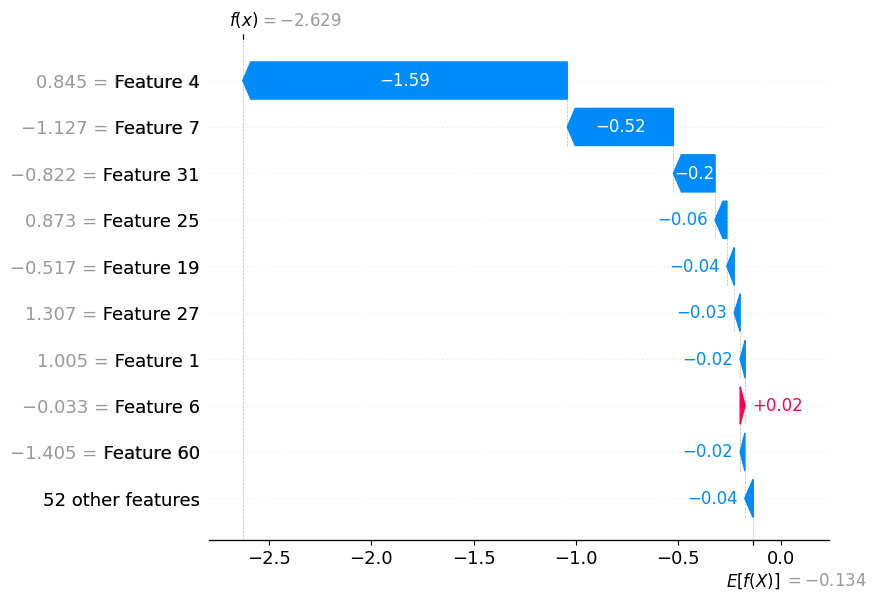

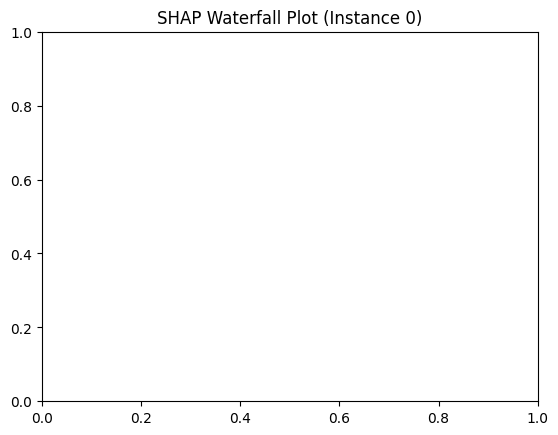

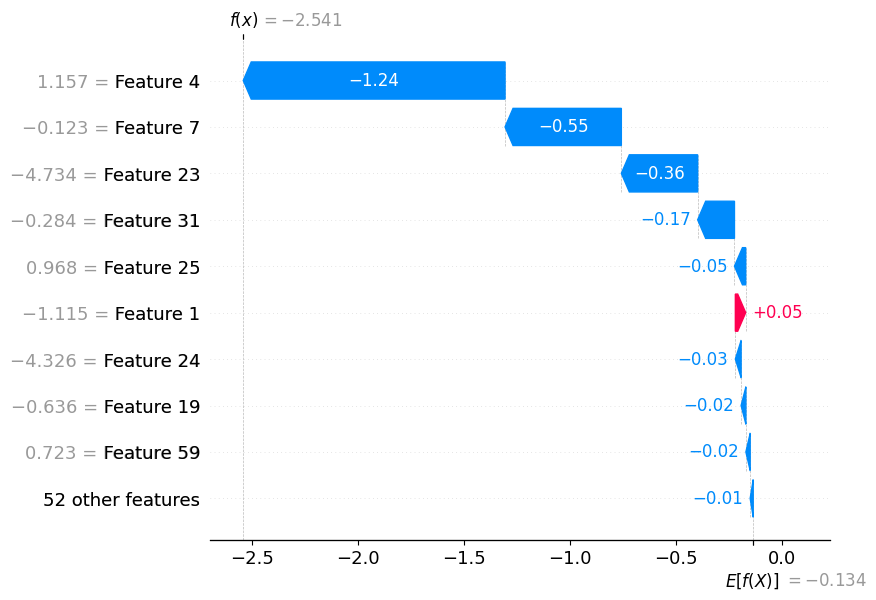

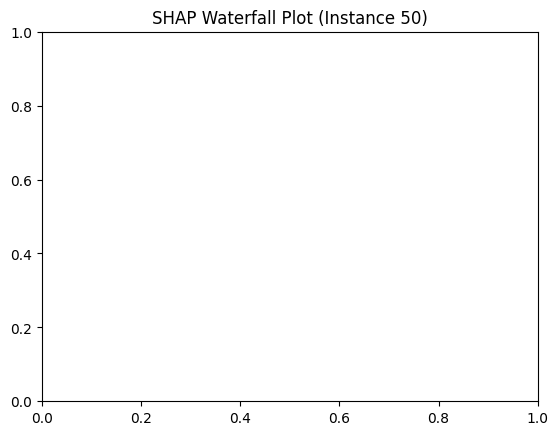

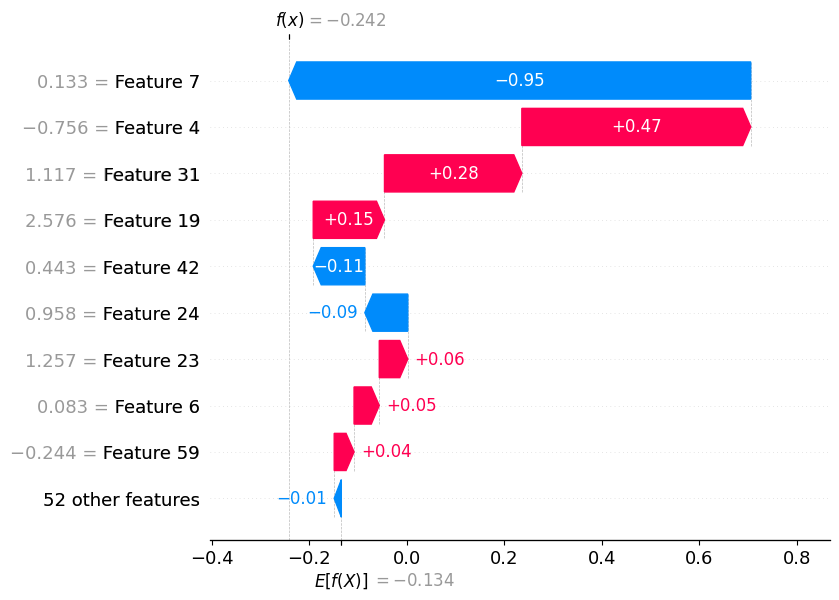

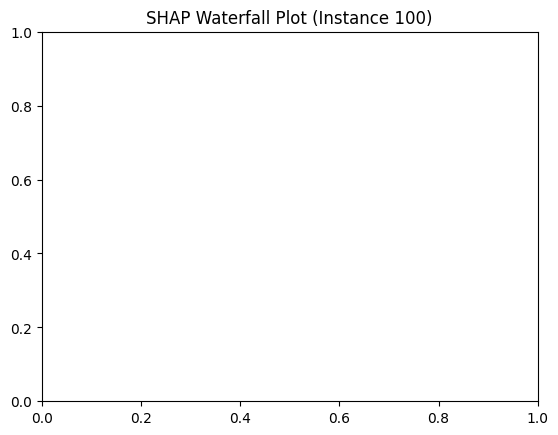

In [94]:
for i in [0, 50, 100]:  # Adjust indices as needed
    shap.plots.waterfall(shap_values[i])
    plt.title(f"SHAP Waterfall Plot (Instance {i})")
    plt.show()

# c) SHAP Dependence Plots (for 3 features)

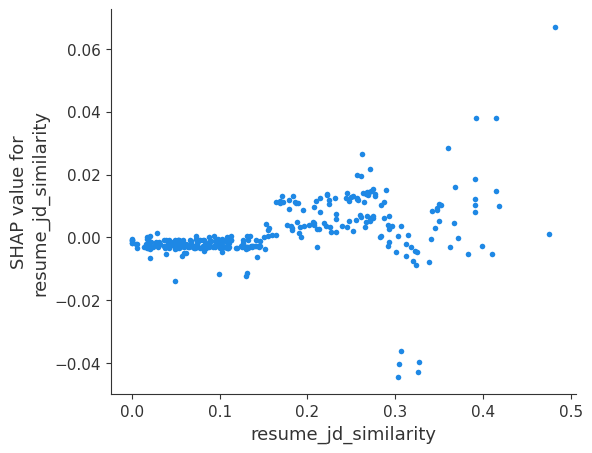

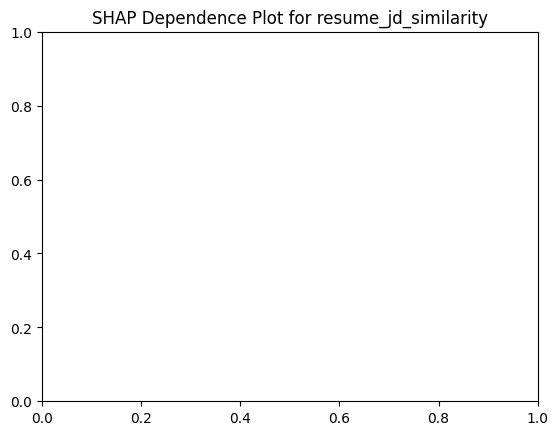

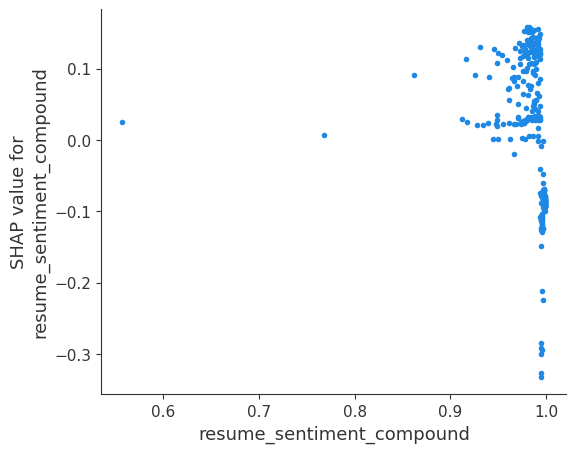

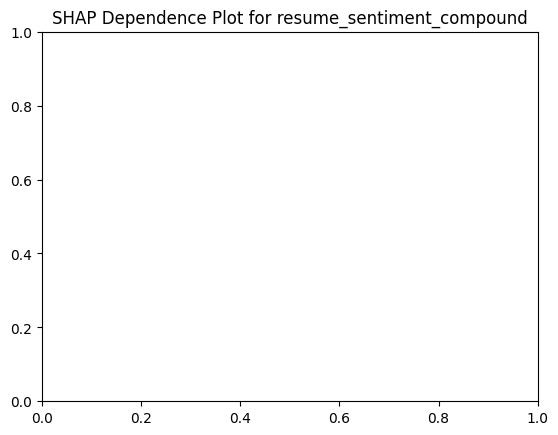

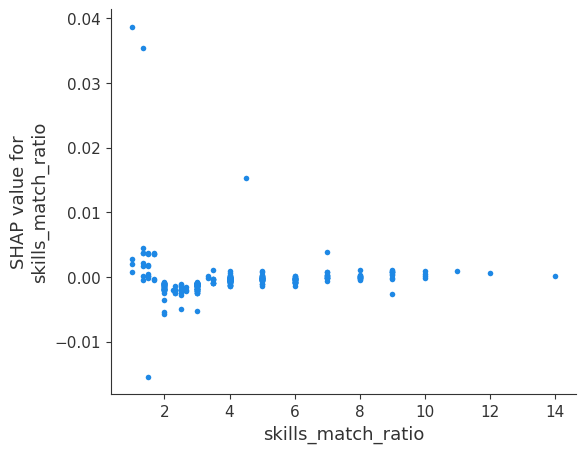

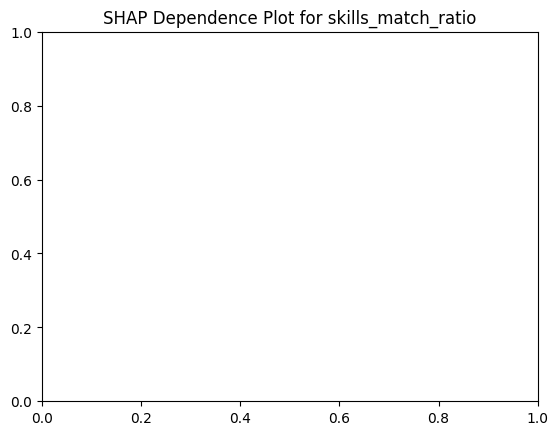

In [95]:
for feature in ["resume_jd_similarity", "resume_sentiment_compound", "skills_match_ratio"]:  # Replace with actual feature names
    shap.dependence_plot(feature, shap_values.values, X_test, interaction_index=None)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.show()

# Step 5: Generate Partial Dependence Plots (PDPs)

In [97]:
!pip install pdpbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.9 MB/s eta 0:00:00


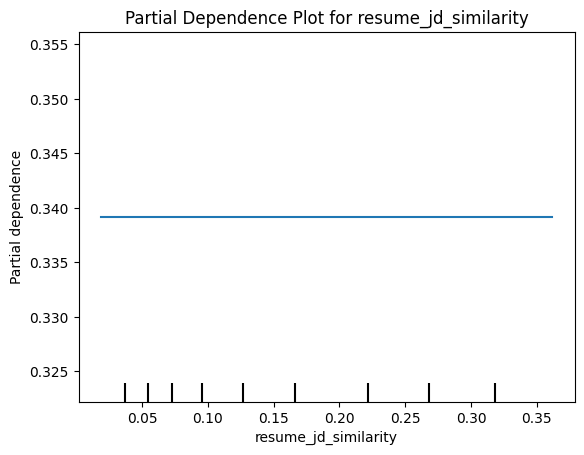

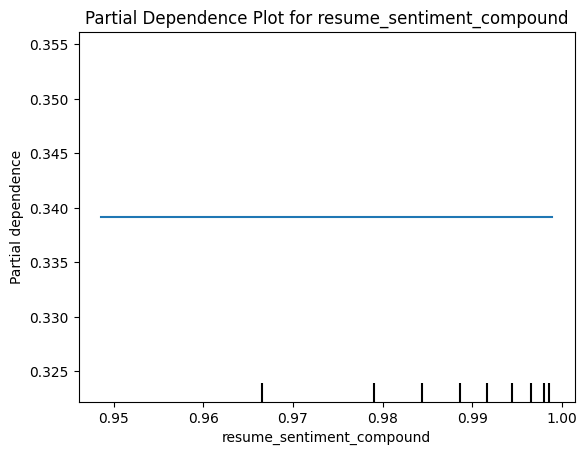

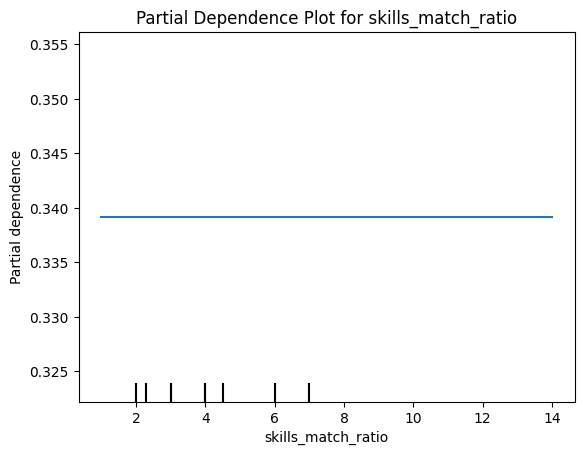

In [104]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt

# Ensure X_test is a DataFrame with proper column names
if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=X_train.columns)  # Assuming X_train has correct column names
else:
    X_test_df = X_test

# List of features for PDP
selected_features = ["resume_jd_similarity", "resume_sentiment_compound", "skills_match_ratio"]  # Replace with actual feature names
available_features = [feature for feature in selected_features if feature in X_test_df.columns]

if not available_features:
    raise ValueError("None of the selected features are found in the dataset. Please verify feature names.")

# Generate PDP for each feature
for feature in available_features:
    try:
        feature_index = X_test_df.columns.get_loc(feature)  # Get feature index
        disp = PartialDependenceDisplay.from_estimator(
            best_xgb_model,
            X_test_df,
            features=[feature_index],
            feature_names=X_test_df.columns,
            grid_resolution=100,
        )
        plt.title(f"Partial Dependence Plot for {feature}")
        plt.show()
    except Exception as e:
        print(f"Error generating PDP for feature '{feature}': {e}")


Convert Log Odds to Probability

In [107]:
def log_odds_to_probability(log_odds):
    return np.exp(log_odds) / (1 + np.exp(log_odds))

# Apply to SHAP values or PDP outputs (example for SHAP values):
probabilities = log_odds_to_probability(shap_values.values)